# Tiled Cholesky Factorization


We illustrate here the use of `DataFlowTasks` to parallelize a tiled Cholesky
factorization. The implementation shown here is delibarately made as simple
and self-contained as possible; a more complex and more efficient
implementation can be found in the
[TiledFactorization](https://github.com/maltezfaria/TiledFactorization)
package.

The Cholesky factorization algorithm takes a symmetric positive definite
matrix $A$ and finds a lower triangular matrix $L$ such that $A = LLᵀ$. The
tiled version of this algorithm decomposes the matrix $A$ into tiles (of even
sizes, in this simplified version). At each step of the algorithm, we do a
Cholesky factorization on the diagonal tile, use a triangular solve to update
all of the tiles at the right of the diagonal tile, and finally update all the
tiles of the submatrix with a schur complement.

If we have a matrix $A$ decomposed in $n \times n$ tiles, then the algorithm will
have $n$ steps. The $i$-th step (with $i \in [1:n]$) performs:

-  $1$ cholesky factorization of the $(i,i)$ tile,
-  $(i-1)$ triangular solves (one for each tile in the $i$-th row of the upper triangular matrix),
-  $i(i-1)/2$ matrix multiplications to update the submatrix.

These are the basic operations on tiles, which we are going to spawn in
separate tasks in the parallel implementation. Accounting for all iterations,
this makes a total of $\mathcal{O}(n^3)$ such tasks, decomposed as:

-  $\mathcal{O}(n)$ cholesky factorizations,
-  $\mathcal{O}(n^2)$ triangular solves,
-  $\mathcal{O}(n^3)$ matrix multiplications.

The following image illustrates the 2nd step of the algorithm:

![](Cholesky_2ndStep.png)

## Sequential implementation

A sequential tiled factorization algorithm can be implemented as:

In [1]:
const USE_MKL = false
USE_MKL && using MKL

using LinearAlgebra

tilerange(ti, ts) = (ti-1)*ts+1:ti*ts

function cholesky_tiled!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization
        cholesky!(T[i,i])

        # Left tiles update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            ldiv!(U', T[i,j])
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                mul!(T[j,k], T[i,j]', T[i,k], -1, 1)
            end
        end
    end

    # Construct the factorized object
    return Cholesky(A, 'U', zero(LinearAlgebra.BlasInt))
end

cholesky_tiled! (generic function with 1 method)

Let us build a small test case to check the correctness of the
factorization. Here we divide a matrix of size 4096×4096 in 8×8 tiles of size
512×512:

In [2]:
n  = 4096
ts = 512
A = rand(n, n)
A = (A + adjoint(A))/2
A = A + n*I;

and the results seem to be correct:

In [3]:
F = cholesky_tiled!(copy(A), ts)

# Check results
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))
@show err
@assert err < eps(Float64)

err = 1.734448888884118e-17


## Parallel implementation

In order to parallelize the code with `DataFlowTasks.jl`, function calls
acting on tiles are wrapped within `@spawn`, along with annotations
describing data access modes. We also give meaningful labels to the tasks,
which will help debug and profile the code.

In [4]:
using DataFlowTasks
using DataFlowTasks: @spawn

function cholesky_dft!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization
        @spawn cholesky!(@RW(T[i,i])) label="chol ($i,$i)"

        # Left tiles update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            @spawn ldiv!(@R(U)', @RW(T[i,j])) label="ldiv ($i,$j)"
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                @spawn mul!(@RW(T[j,k]), @R(T[i,j])', @R(T[i,k]), -1, 1) label="schur ($j,$k)"
            end
        end
    end

    # Construct the factorized object
    r = @spawn Cholesky(@R(A), 'U', zero(LinearAlgebra.BlasInt)) label="result"
    return fetch(r)
end

cholesky_dft! (generic function with 1 method)

Again, let us check the correctness of the result:

In [5]:
F = cholesky_dft!(copy(A), ts)

# Check results
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))
@show err
@assert err < eps(Float64)

err = 1.734448888884118e-17


## Debugging and Profiling

Let us now check what happens during a parallel run of our cholesky
factorization. Thanks to the test above, the code is now compiled. Let's re-run it and collect
meaningful profiling information:

In [6]:
# Clean profiling environment
GC.gc()

# Real workload to be analysed
Ac = copy(A)
log_info = DataFlowTasks.@log cholesky_dft!(Ac, ts)

LogInfo with 121 logged tasks


The number of tasks being $\mathcal{O}(n^3)$, we can see how quickly the DAG
complexity increases (even though the test case only has 8×8 tiles here):

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.9/Project.toml`
  [13f3f980] CairoMakie v0.10.12
  [e9467ef8] GLMakie v0.8.12
  [f526b714] GraphViz v0.2.0
  [ee78f7c6] Makie v0.19.12
[ Info: Loading DataFlowTasks dag plot utilities


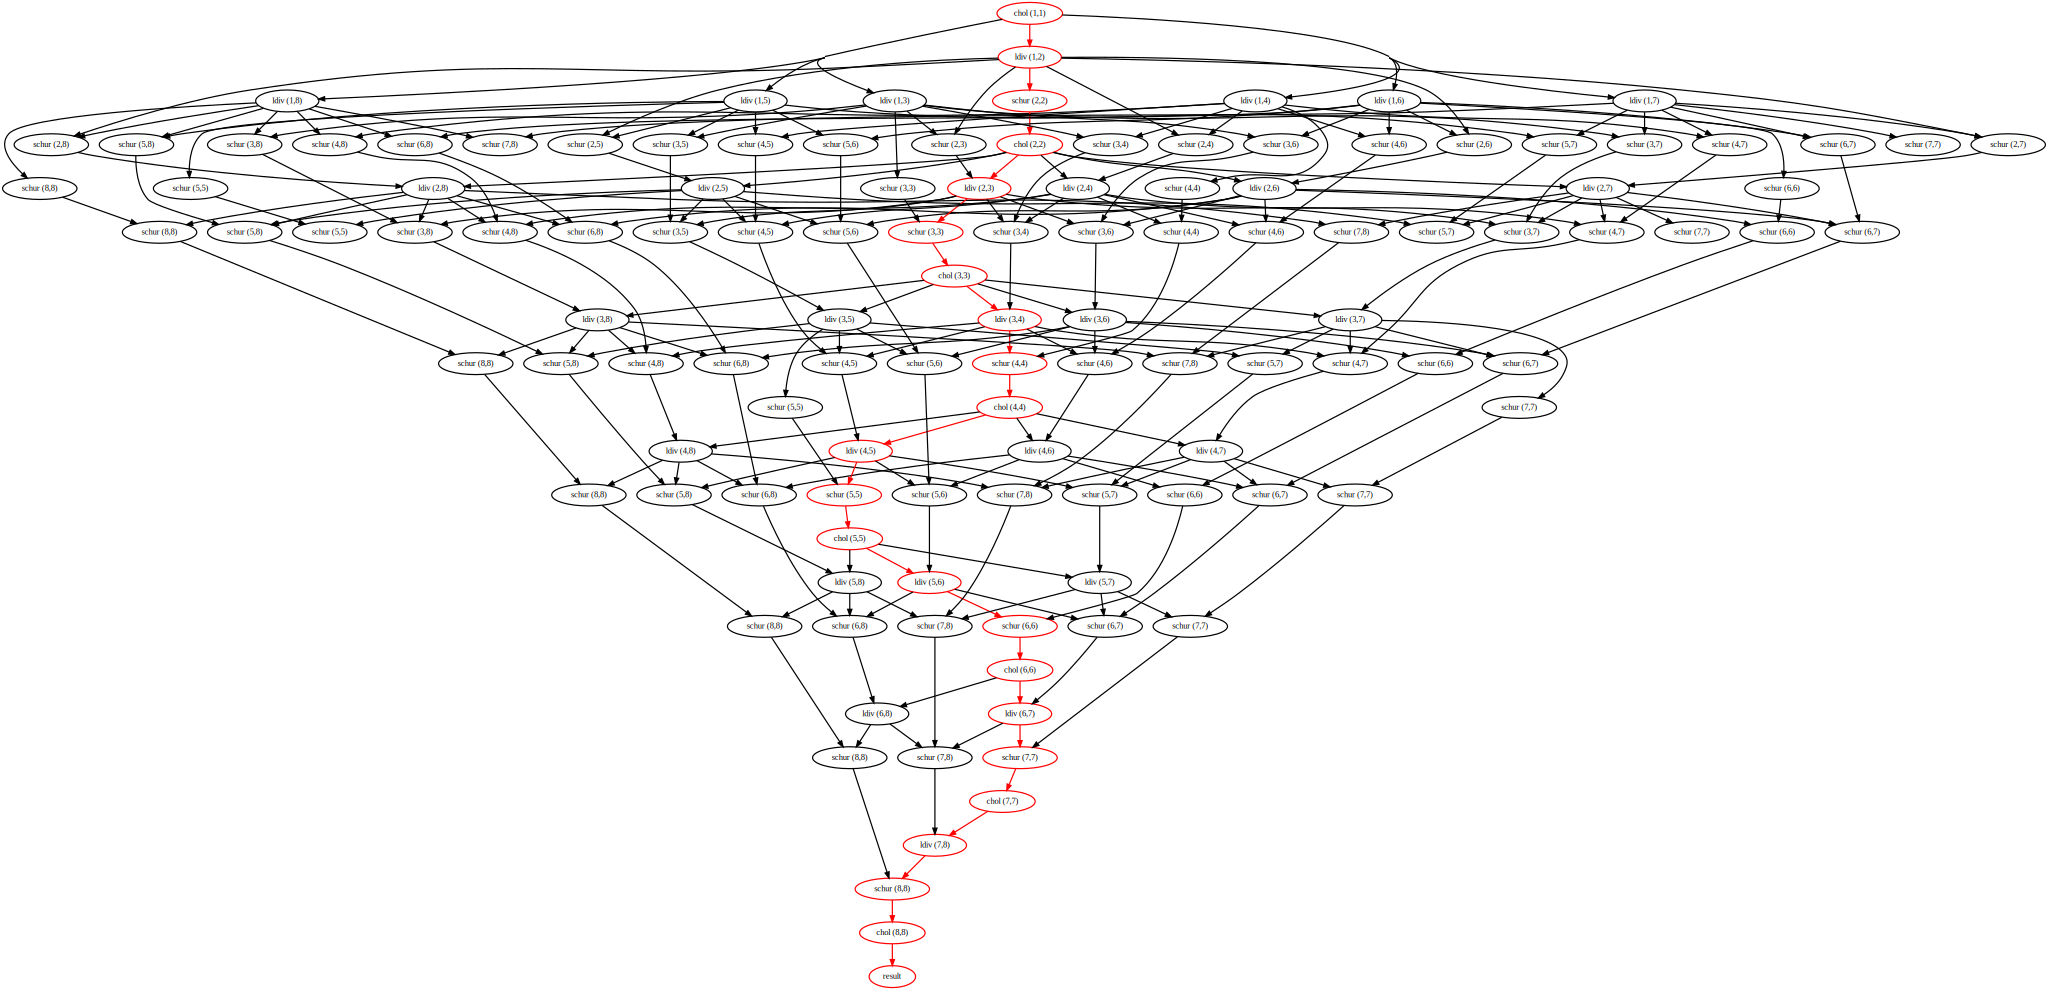

In [7]:
DataFlowTasks.stack_weakdeps_env!()
using GraphViz
dag = GraphViz.Graph(log_info)

The critical path, highlighted in red, includes all cholesky factorizations of
diagonal tiles, as well as the required tasks in between them.

We can also readily get more details about the performance limiting factors:

In [8]:
DataFlowTasks.describe(log_info; categories=["chol", "ldiv", "schur"])

• Elapsed time           : 0.244
  ├─ Critical Path       : 0.200
  ╰─ No-Wait             : 0.185

• Run time               : 1.954
  ├─ Computing           :   1.483
  │  ├─ chol             :     0.084
  │  ├─ ldiv             :     0.209
  │  ├─ schur            :     1.190
  │  ╰─ unlabeled        :     0.000
  ├─ Task Insertion      :   0.004
  ╰─ Other (idle)        :   0.468


and, at the price of loading `Makie`, display these in a more convenient
profile plot:

[ Info: Loading DataFlowTasks general plot utilities
[ Info: Computing    : 1.4828123029999998
[ Info: Inserting    : 0.0040329580000000005
[ Info: Other        : 0.467553905628718


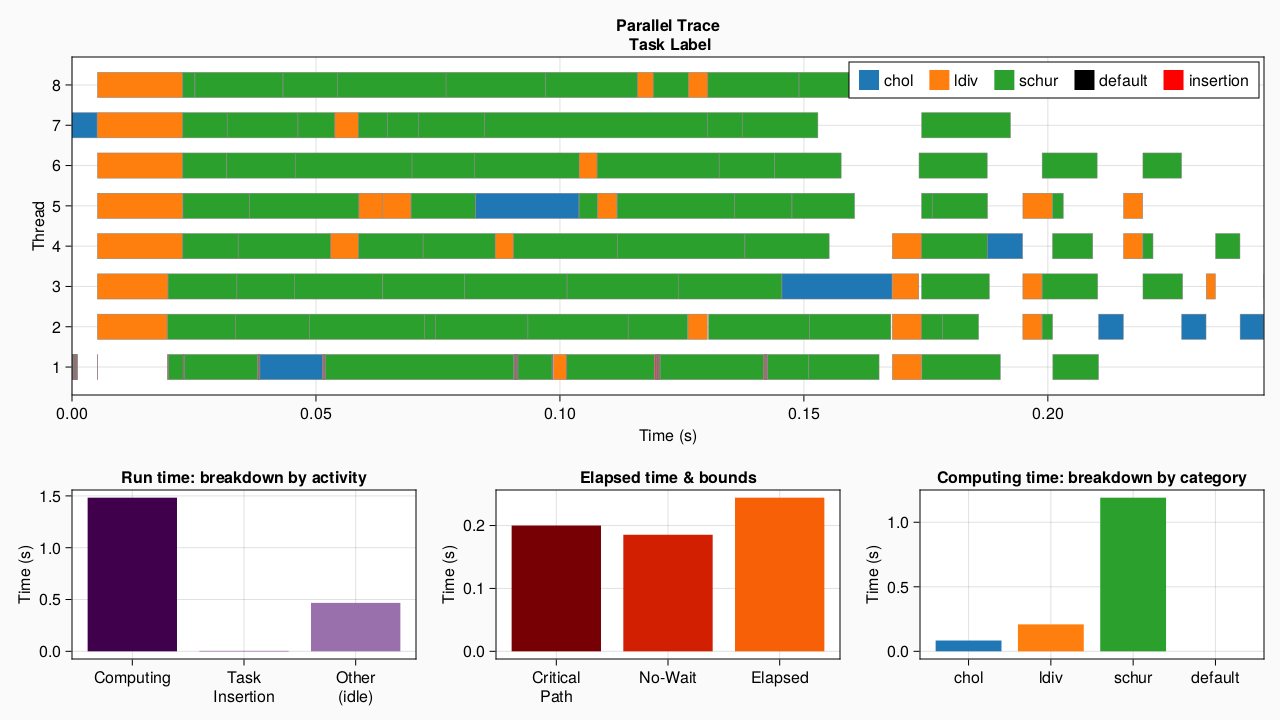

In [9]:
using CairoMakie # or GLMakie in order to have more interactivity
trace = plot(log_info; categories=["chol", "ldiv", "schur"])

The overhead incurred by `DataFlowTasks` seems relatively small here: the time
taken inserting tasks is barely measurable, and the scheduling did not lead to
threads waiting idly for too long. This is confirmed by the bottom middle plot,
showing a measured wall clock time not too much longer than the lower bound
obtained when suppressing idle time.

The "Computing time: breakdown by category" plot seems to indicate that the
matrix multiplications performed in the "Schur" tasks account for the majority
of the computing time, suggeseting we should optimize this to increase the
sequential performance of the factorization.

# Performances

To benchmark the performance, we will compare our somewhat naive
implementation to the one provided by our system's BLAS library. We will use
[OpenBlas](https://www.openblas.net) here because it is the default BLAS
library on our system, but if you have access to Intel's MKL, you should
probably use it! Here is a simple benchmark:

In [10]:
using BenchmarkTools

# n × n symmetric positive definite matrix
function spd_matrix(n)
    A = rand(n, n)
    A = (A + adjoint(A))/2
    return A + n*I
end

function bench_blas(n)
    nt = Threads.nthreads()
    BLAS.set_num_threads(nt)
    return @belapsed cholesky!(A) setup=(A=spd_matrix($n)) evals=1
end

function bench_dft(n;tilesize=512)
    BLAS.set_num_threads(1)
    return @belapsed cholesky_dft!(A, $tilesize) setup=(A=spd_matrix($n)) evals=1
end

bench_dft (generic function with 1 method)

Let us compare the performances of the default *BLAS*  library and ours:

In [11]:
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libopenblas64_.so

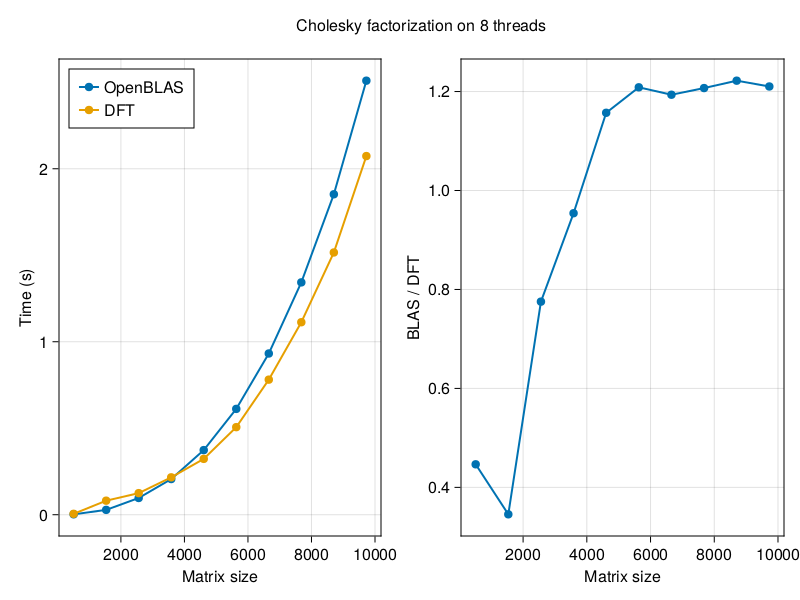

In [12]:
nsizes = 512 .* (1:2:20)
tblas  = map(bench_blas, nsizes)
tdft   = map(bench_dft, nsizes)

fig = Figure()
ax  = Axis(fig[1,1], xlabel="Matrix size", ylabel="Time (s)")
scatterlines!(ax, nsizes, tblas, label= USE_MKL ? "MKL" : "OpenBLAS", linewidth=2)
scatterlines!(ax, nsizes, tdft, label="DFT", linewidth=2)
axislegend(position=:lt)

ax  = Axis(fig[1,2], xlabel="Matrix size", ylabel="BLAS / DFT")
scatterlines!(ax, nsizes, tblas ./ tdft, linewidth=2)
fig[0, :] = Label(fig, "Cholesky factorization on $(Threads.nthreads()) threads")
fig

!!! note "Using MKL"
    To use the [Intel MKL
    library](https://en.wikipedia.org/wiki/Math_Kernel_Library), you need set
    the `USE_MKL` variable at the top of this notebook to `true`, and re-run
    this notebook on a new Julia session. That is because the `MKL.jl` package
    must be the first package to be loaded (see [this
    link](https://docs.juliahub.com/MKL/tDGGv/0.4.4/#Usage))

The performance of this example can be improved by using better
implementations for the sequential building blocks operating on tiles:

- `LoopVectorization.jl` can improve the performance of the sequential
  cholesky factorization of diagonal blocks as well as the `schur_complement`
- `TriangularSolve.jl` provides a high-performance `ldiv!` implementation

This approach is pursued in
[`TiledFactorization.jl`](https://github.com/maltezfaria/TiledFactorization),
where all the above mentioned building blocks are combined with the
parallelization strategy presented here to create a *pure Julia*
implementation of the matrix factorizations. The performances of this
implementation is assessed in the following plot, by comparison to MKL on a
the case of a 5000x5000 matrix decomposed in tiles of size 256x256.

![](cholesky_scaling.png)

The figure above was generated by running [this
script](https://github.com/maltezfaria/TiledFactorization/blob/daafed7b6981853b6c71e7441fd9b212582836db/benchmarks/cholesky_scaling.sh)
on a machine with 2x10 Intel Xeon Silver 4114 cores (2.20GHz) with the following topology:

![](lfaria-precision-7920-tower-lstopo.png)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*